# Libraries

In [1]:
import json
import pandas as pd
import numpy as np
import stanza
import importlib

from matplotlib import pyplot as plt
import seaborn as sns
plt.rcParams["figure.figsize"] = (8,5)
import plotly.express as px

import warnings
warnings.filterwarnings("ignore")

C:\Users\leona\anaconda3\lib\site-packages\xarray\backends\cfgrib_.py:27: UserWarning: Failed to load cfgrib - most likely there is a problem accessing the ecCodes library. Try `import cfgrib` to get the full error message
  warnings.warn(


In [2]:
import Visualizations
importlib.reload(Visualizations)

<module 'Visualizations' from 'C:\\Users\\leona\\Google Drive\\Università\\5\\Stage\\codice\\Visualizations.py'>

In [99]:
import TweetsProcessing
importlib.reload(TweetsProcessing)

2022-04-12 11:21:11 INFO: Downloading default packages for language: it (Italian)...
2022-04-12 11:21:12 INFO: File exists: C:\Users\leona\stanza_resources\it\default.zip.
2022-04-12 11:21:14 INFO: Finished downloading models and saved to C:\Users\leona\stanza_resources.
2022-04-12 11:21:14 WARNING: Language it package default expects mwt, which has been added
2022-04-12 11:21:14 INFO: Loading these models for language: it (Italian):
| Processor | Package  |
------------------------
| tokenize  | combined |
| mwt       | combined |
| lemma     | combined |
| ner       | fbk      |

2022-04-12 11:21:14 INFO: Use device: cpu
2022-04-12 11:21:14 INFO: Loading: tokenize
2022-04-12 11:21:14 INFO: Loading: mwt
2022-04-12 11:21:14 INFO: Loading: lemma
2022-04-12 11:21:14 INFO: Loading: ner
2022-04-12 11:21:15 INFO: Done loading processors!


<module 'TweetsProcessing' from 'C:\\Users\\leona\\Google Drive\\Università\\5\\Stage\\codice\\TweetsProcessing.py'>

# Load tweets

In [4]:
lang = 'it'

with open('tweets_mfw_' + lang + '.json', 'r') as f:
    data = json.load(f)
    
len(data['tweets'])

2327

In [5]:
tweets = []

for tw in data['tweets']:
    u = {}
    u['time'] = tw['created_at']
    u['full_text'] = tw['text']
    u['hashtags'] = [h['text'] for h in tw['entities']['hashtags']]
    u['user_location'] = tw['user']['location']
    u['user_followers'] = tw['user']['followers_count']
    u['user_name'] = tw['user']['name']
    u['retweets'] = tw['retweet_count']

    if tw['geo'] is not None:
        u['geo'] = [tw['geo']['coordinates'], tw['place']['full_name']]
    else:
        u['geo'] = None

    tweets.append(u)

In [6]:
tweets[0]

{'time': 'Wed Sep 29 08:56:00 +0000 2021',
 'full_text': 'RT @domenicodec1: Una delle mie piazze preferite: Piazza Duomo, Milano. #Milan #piazzaduomo #mfw #milanofashionweek https://t.co/SYsuQ9XRKw',
 'hashtags': ['Milan', 'piazzaduomo', 'mfw', 'milanofashionweek'],
 'user_location': '',
 'user_followers': 6473,
 'user_name': 'めい(KYOKO-KAWA)',
 'retweets': 1,
 'geo': None}

# Sentiment analysis

In [7]:
%%time

cache = {}
topic_words = ['milano', 'milan', 'fashion', 'week', 'mfw', 'milanofashionweek']
language = TweetsProcessing.get_extended_language(lang)

for i in range(len(tweets)):
    full_text = tweets[i]['full_text']
    full_text = full_text.replace('RT ', '')
    
    if full_text not in cache:
        cache[full_text] = TweetsProcessing.process_tweet(full_text, language, topic_words)
    
    tweets[i]['text'] = cache[full_text]['text']
    tweets[i]['entities'] = cache[full_text]['entities']
    tweets[i]['valence'] = cache[full_text]['valence']
    tweets[i]['arousal'] = cache[full_text]['arousal']
    tweets[i]['emotion'] = cache[full_text]['emotion']
    tweets[i]['sentiment'] = cache[full_text]['sentiment']

Wall time: 8min 18s


In [8]:
with open('tweets_mfw_' + lang + '_processed.json', 'w') as f:
    json.dump(tweets, f)

# Read processed tweets

In [9]:
with open('tweets_mfw_' + lang + '_processed.json', 'r') as f:
    tweets = json.load(f)

# Tweets over time

In [149]:
tmp = TweetsProcessing.get_fields(tweets, ['time'], as_df=True)
tmp.index = pd.to_datetime(tmp['time'])
del tmp['time']
tmp['value'] = [1]*len(tmp)
tmp = tmp.resample('30min').sum()

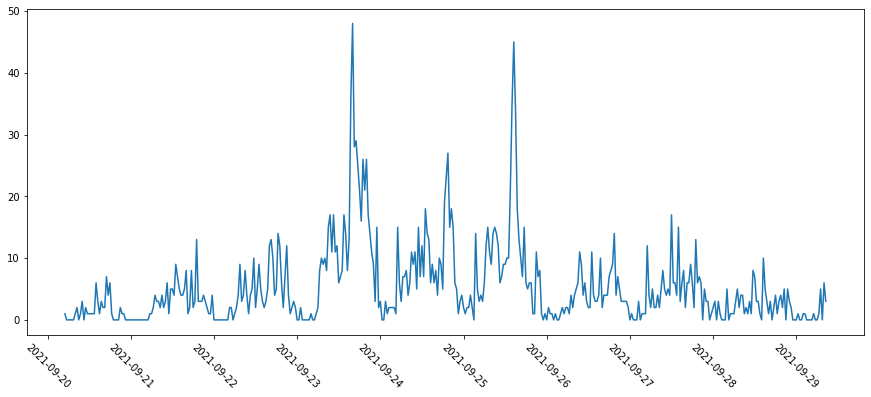

In [150]:
plt.rcParams["figure.figsize"] = (15,6)

plt.plot(tmp)
plt.xticks(rotation=-45)
plt.show()

plt.rcParams["figure.figsize"] = (8,5)

# Stacked Area Chart

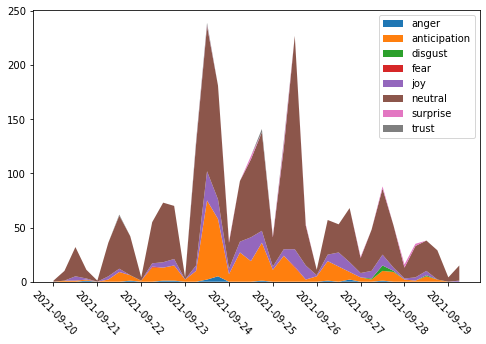

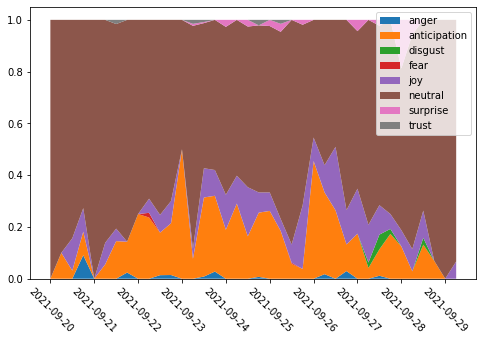

In [151]:
tmp = TweetsProcessing.get_count_by_time(tweets, 'emotion', '6h', False)
Visualizations.stackplot(tmp)

tmp = TweetsProcessing.get_count_by_time(tweets, 'emotion', '6h', True)
Visualizations.stackplot(tmp)

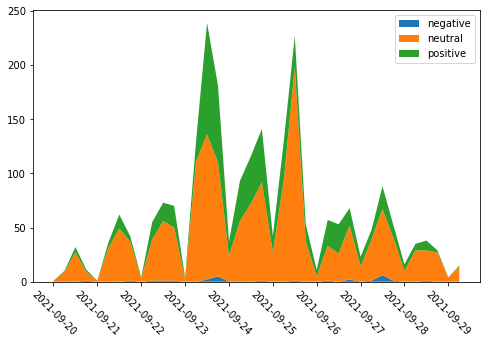

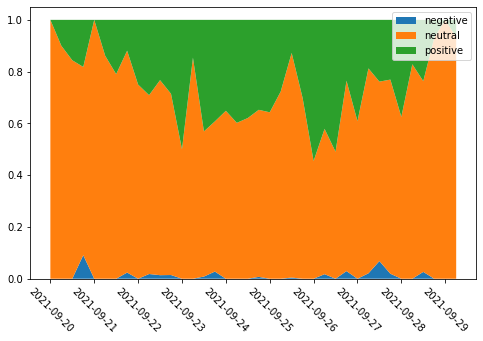

In [152]:
tmp = TweetsProcessing.get_count_by_time(tweets, 'sentiment', '6h', False)
Visualizations.stackplot(tmp)

tmp = TweetsProcessing.get_count_by_time(tweets, 'sentiment', '6h', True)
Visualizations.stackplot(tmp)

# Wordcloud


anger


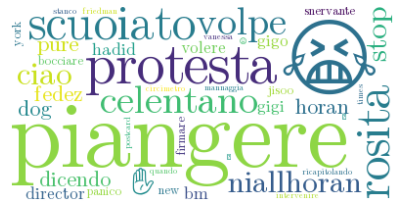


fear


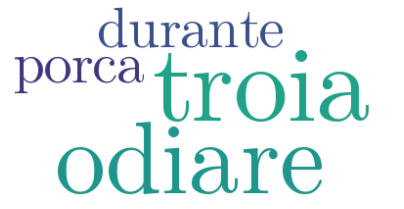


disgust


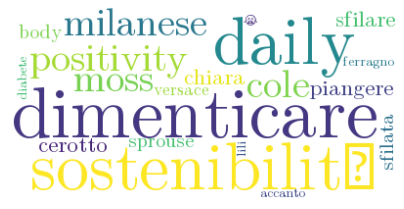


neutral


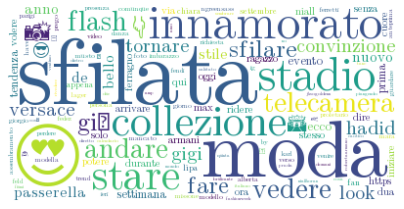


anticipation


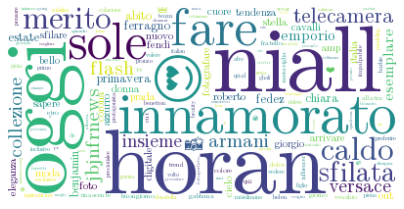


joy


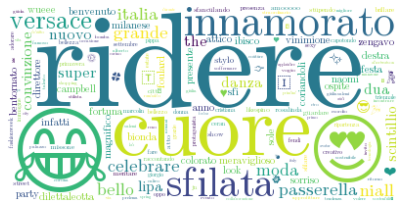


surprise


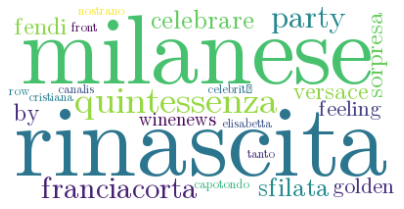


trust


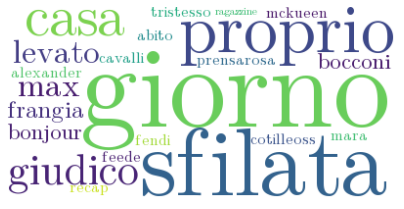

In [12]:
_type = 'emotion'
sent_list = TweetsProcessing.EMOTIONS

for emotion in sent_list:
    filtered_tweets = TweetsProcessing.get_tweets(tweets, _type, emotion)
    texts = TweetsProcessing.get_field(filtered_tweets, 'text')
    if len(texts) > 0:
        texts = ' '.join(texts).split()
        freq = pd.value_counts(texts)
    
        print()
        print(emotion)
        Visualizations.wordcloud(freq)


negative


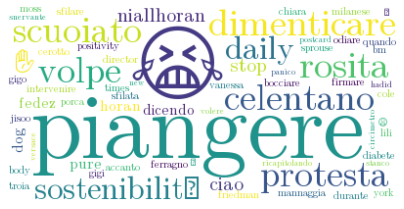


neutral


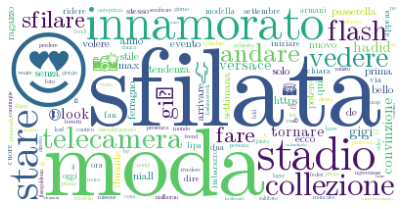


positive


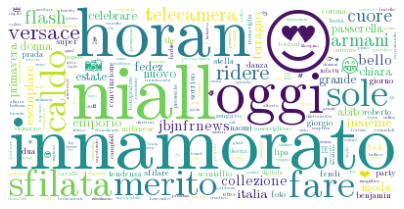

In [13]:
_type = 'sentiment'
sent_list = TweetsProcessing.SENTIMENTS

for sent in sent_list:
    filtered_tweets = TweetsProcessing.get_tweets(tweets, _type, sent)
    texts = TweetsProcessing.get_field(filtered_tweets, 'text')
    if len(texts) > 0:
        texts = ' '.join(texts).split()
        freq = pd.value_counts(texts)
    
        print()
        print(sent)
        Visualizations.wordcloud(freq)

# Statistiche generali

In [208]:
name = 'Milano'
_type = 'entities'

In [209]:
tmp = TweetsProcessing.get_tweets(tweets, _type, name)
stats = TweetsProcessing.get_stats(tmp)

In [210]:
print('\n --- ' + _type + ': ' + name)

print('\n --- Number of tweets:', stats['count'])

field = 'emotion'
df = pd.DataFrame({field: stats[field].values()}, index=stats[field].keys())
fig = px.pie(df, values=field, names=df.index, hole=.6, title=field, width=500, height=400)
fig.show()

field = 'sentiment'
df = pd.DataFrame({field: stats[field].values()}, index=stats[field].keys())
fig = px.pie(df, values=field, names=df.index, hole=.6, title=field, width=500, height=400)
fig.show()


 --- entities: Milano

 --- Number of tweets: 1338


In [211]:
print('\n --- Avg valence:', np.mean([v for v in stats['valence'] if v is not None]))
print('\n --- Avg arousal:', np.mean([v for v in stats['arousal'] if v is not None]))

df = pd.DataFrame({'valence': stats['valence'], 'arousal': stats['arousal'], 'text': stats['texts']}).dropna()

fig = px.scatter(df, x="valence", y="arousal", 
                 hover_data={'text': True}, 
#                  size='count',
                 color='valence', 
                 color_continuous_scale=px.colors.sequential.Agsunset, 
                 range_color=(-1,1),
                 width=900, height=700)

fig.update_layout(xaxis_range=[-1,1])
fig.update_layout(yaxis_range=[-1,1])
fig.show()


 --- Avg valence: 0.3204004984441648

 --- Avg arousal: -0.06954582496468803


# Influencers distribution

In [47]:
user_list = TweetsProcessing.get_list(tweets, 'user_name')
bio = [TweetsProcessing.get_user_bio(tweets, user) for user in user_list]
location_list = [x[0] for x in bio]
followers_list = [x[1] for x in bio]
tmp = pd.DataFrame({'username': user_list, 'followers': followers_list, 'location': location_list})
tmp = tmp.sort_values(by='followers', ascending=False).head(20)

In [48]:
fig = px.bar(tmp, x='followers', y='username', 
             hover_data={'location': True},
             color='followers', color_continuous_scale=px.colors.sequential.Redor)
fig.update_layout(barmode='stack', yaxis={'categoryorder':'total ascending'})
fig.update_coloraxes(showscale=False)
fig.show()

# Hashtags distribution

In [57]:
hashtags_list = TweetsProcessing.get_list(tweets, 'hashtags')
count = [len(TweetsProcessing.get_tweets(tweets, 'hashtags', h)) for h in hashtags_list]
tmp = pd.DataFrame({'hashtag': hashtags_list, 'count': count})
tmp = tmp.sort_values(by='count', ascending=False).head(20)

In [58]:
fig = px.bar(tmp, x='count', y='hashtag', 
             color='count', color_continuous_scale=px.colors.sequential.Redor)
fig.update_layout(barmode='stack', yaxis={'categoryorder':'total ascending'})
fig.update_coloraxes(showscale=False)
fig.show()

# Entities distribution

In [191]:
entities_list = TweetsProcessing.get_list(tweets, 'entities')
count = [len(TweetsProcessing.get_tweets(tweets, 'entities', h)) for h in entities_list]
tmp = pd.DataFrame({'entity': entities_list, 'count': count})
tmp = tmp.sort_values(by='count', ascending=False).head(20)

In [192]:
fig = px.bar(tmp, x='count', y='entity', 
             color='count', color_continuous_scale=px.colors.sequential.Redor)
fig.update_layout(barmode='stack', yaxis={'categoryorder':'total ascending'})
fig.update_coloraxes(showscale=False)
fig.show()